In [116]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [144]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

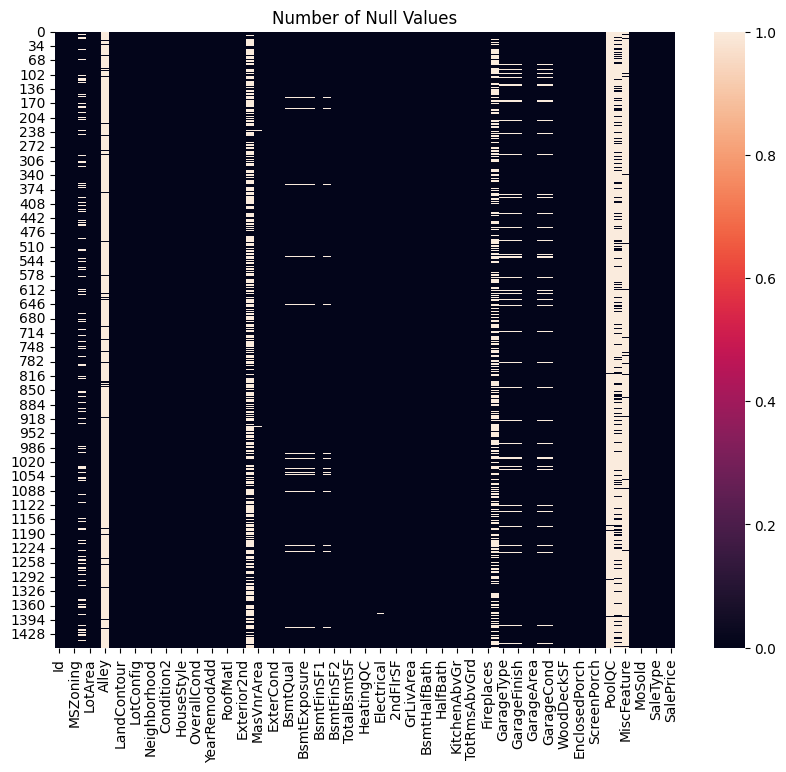

In [127]:
plt.figure(figsize=(10,8))
sns.heatmap(train.isnull(),cbar=True)
plt.title("Number of Null Values")
plt.show()

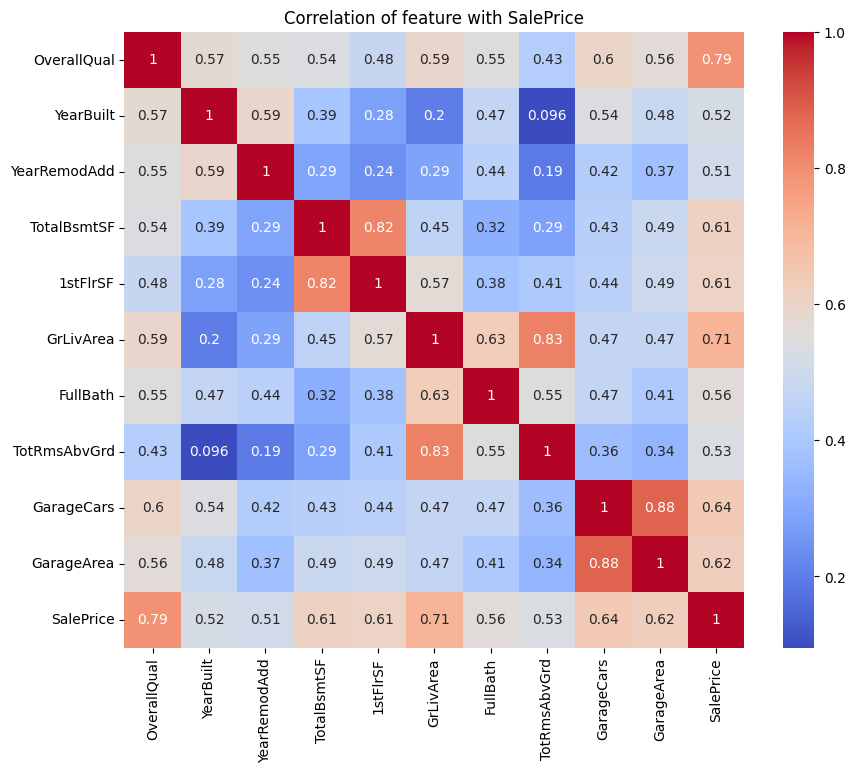

In [128]:
plt.figure(figsize=(10,8))
train_ = train.drop(columns=["Id"]) # Id is irrelevant for corr
train_n = train_[train_.select_dtypes(include="number").columns] # select only the num for corr
corr = train_n.corr() # corr
top_corr = corr.index[abs(corr["SalePrice"])>0.5] # Select feature with top correlation with SalePrice
sns.heatmap(train_n[top_corr].corr(),annot=True,cmap="coolwarm") # make correlation map , annot = gives value inside square , cmap = "red to blue"
plt.title("Correlation of feature with SalePrice")
plt.show()

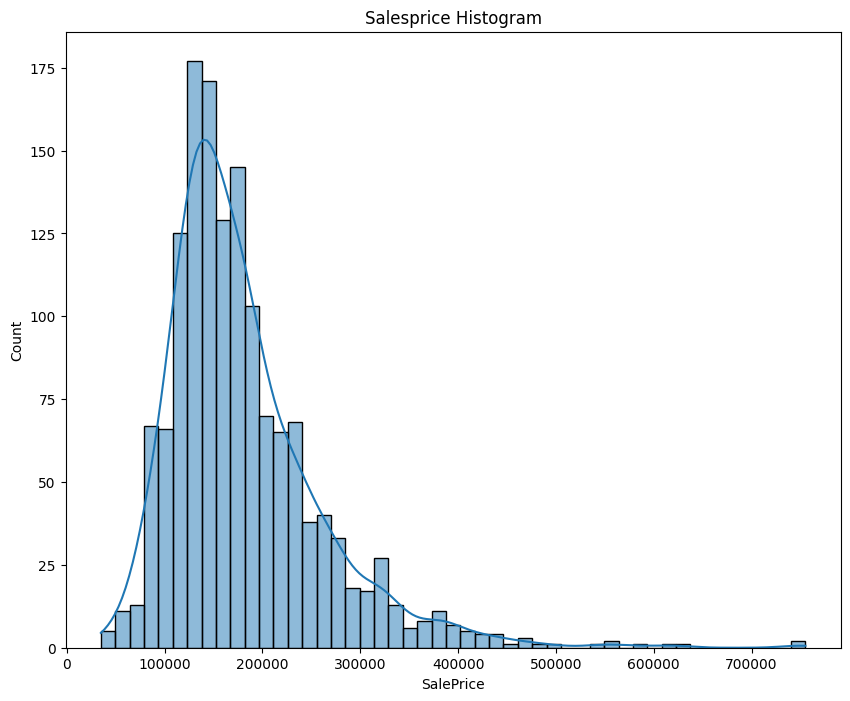

In [129]:
plt.figure(figsize=(10,8))
sns.histplot(train["SalePrice"],kde=True,bins="auto")
plt.title("Salesprice Histogram")
plt.show()

In [130]:
train_id = train["Id"]
X = train.drop(columns=["Id","SalePrice"])
y = np.log1p(train["SalePrice"])
test_final = test.drop(columns=["Id"])

In [133]:
num_col = X.select_dtypes(include="number").columns
cat_col = X.select_dtypes(exclude="number").columns

train_num = X[num_col]
test_num = test_final[num_col]

train_cat = X[cat_col]
test_cat = test_final[cat_col]

In [134]:
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

train_num_imputed = num_imputer.fit_transform(train_num)
test_num_imputed = num_imputer.transform(test_num)

train_cat_imputed = cat_imputer.fit_transform(train_cat)
test_cat_imputed = cat_imputer.transform(test_cat)

In [135]:
encoder = OneHotEncoder(drop="first",handle_unknown="ignore") # to avoid dummy variable trap and ignore unknowns
train_cat_encoded = encoder.fit_transform(train_cat_imputed).toarray()
test_cat_encoded = encoder.transform(test_cat_imputed).toarray()

In [136]:
train_final = np.hstack([train_num_imputed,train_cat_encoded])
test_final = np.hstack([test_num_imputed,test_cat_encoded])

In [ ]:
model = XGBRegressor(
    n_estimators=3000,  # Number of trees
    learning_rate=0.05, # learning rate 
    max_depth=4, # max depth tree can have
    subsample=0.8, # % of rows used on each tree
    colsample_bytree=0.8, # % of columns used on each tree
    reg_alpha=0.1, # L1 Regularization
    reg_lambda=0.1, # L2 Regularization
    random_state=42 # Helps in reproducability
)

In [139]:
kf = KFold(n_splits=5,shuffle=True,random_state=43)
cv = -cross_val_score(model,train_final,y,scoring="neg_root_mean_squared_error",cv=kf)

print(f"Cross Validation Score : {cv.mean()}")

Cross Validation Score : 0.12579729286327868


In [140]:
X_train,X_test,y_train,y_test = train_test_split(train_final,y,test_size=1/3,random_state=42)

In [142]:
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
y_test = np.expm1(y_test)
y_pred = np.expm1(y_pred)

In [143]:
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print(f"RMSE : {rmse}")

RMSE : 30871.15446808658


In [158]:
y_test_real = model.predict(test_final)
y_test_real = np.expm1(y_test_real)

In [159]:
submission = pd.DataFrame(
    {
        "Id" : test["Id"],
        "SalePrice":y_test_real
    }
).set_index("Id")
submission.to_csv("my_submission.csv")